In [ ]:
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = pd.DataFrame()

data_path = r"data"
imaging_path = r"imaging"
filenames = os.listdir(os.path.join(data_path, imaging_path))
depths = pd.read_csv(os.path.join(data_path, "depths.csv"))

for i in filenames:
    img = cv2.imread(os.path.join(data_path, imaging_path, i), 0)
    try:
        depth = depths[depths["Filenames"].str.lower() == i.lower()][
            "Depth from lung surface (in micrometers) where image was acquired"
        ].values[0]
        # some files are named with SK658 and some with Sk658
    except IndexError:
        print(f"couldn't find depth for file {i}")
        continue
    images = pd.concat(
        [images, pd.DataFrame([{"filename": i, "image": img, "depth": depth}])],
        ignore_index=True,
    )

print(images.shape)

couldn't find depth for file MASK_Sk658 Llobe ch010053.jpg
(78, 3)


In [3]:
print(images["filename"])

0     MASK_SK658 Slobe ch010129.jpg
1     MASK_SK658 Slobe ch010115.jpg
2     MASK_SK658 Slobe ch010114.jpg
3     MASK_SK658 Slobe ch010060.jpg
4     MASK_SK658 Slobe ch010048.jpg
                  ...              
73    MASK_SK658 Slobe ch010118.jpg
74    MASK_SK658 Slobe ch010130.jpg
75    MASK_SK658 Slobe ch010078.jpg
76    MASK_SK658 Slobe ch010087.jpg
77    MASK_SK658 Slobe ch010093.jpg
Name: filename, Length: 78, dtype: object


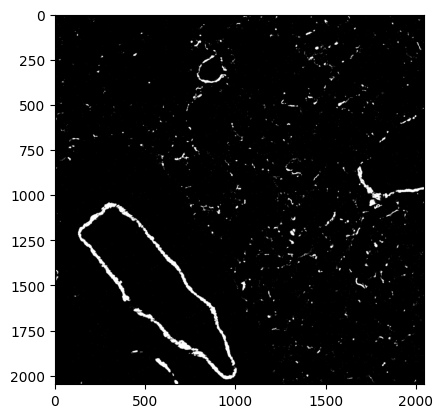

In [13]:
img = (
    images[images["filename"] == "MASK_Sk658 Llobe ch010034.jpg"]["image"]
    .values[0]
    .copy()
)

# convert to rgb instead of grayscale
plt.imshow(img, cmap="gray")
plt.show()

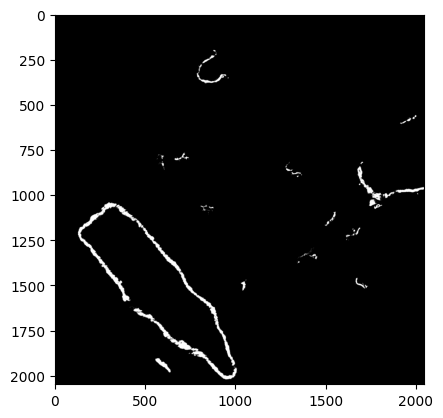

In [14]:
# remove small contours

img_contour_simple = img.copy()

contours, _ = cv2.findContours(img_contour_simple, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cntr in contours:
    if cv2.contourArea(cntr) > 1000:
        continue
    convHull = cv2.convexHull(cntr)
    cv2.drawContours(img_contour_simple, [convHull], -1, (0, 0, 0), thickness=cv2.FILLED)
img_contour_simple = cv2.cvtColor(img_contour_simple, cv2.COLOR_GRAY2RGB)
plt.imshow(img_contour_simple)
plt.show()

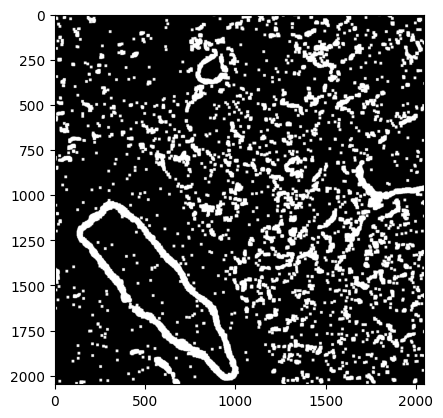

In [15]:
img_dilate = img.copy()
img_dilate = cv2.dilate(img_dilate, np.ones((15, 15), np.uint8), iterations=1)

plt.imshow(img_dilate, cmap="gray")
plt.show()

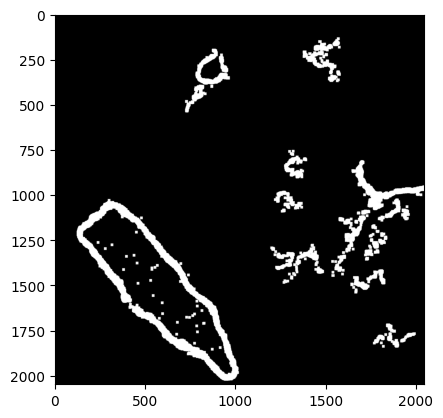

In [16]:
# look at contours on dilated image
img_dilated_contour = img_dilate.copy()
contours, _ = cv2.findContours(img_dilated_contour, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cntr in contours:
    if cv2.contourArea(cntr) > 10000:
        continue
    convHull = cv2.convexHull(cntr)
    cv2.drawContours(img_dilated_contour, [convHull], -1, (0, 0, 0), thickness=cv2.FILLED)
img_dilated_contour = cv2.cvtColor(img_dilated_contour, cv2.COLOR_GRAY2RGB)
plt.imshow(img_dilated_contour)
plt.show()

In [17]:
# combine
img_combine = img_contour_simple.copy()
img_combine = cv2.dilate(
    img_combine, np.ones((15, 15), np.uint8), iterations=1
)
contours, _ = cv2.findContours(
    img_combine, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

for cntr in contours:
    if cv2.contourArea(cntr) > 10000:
        continue
    convHull = cv2.convexHull(cntr)
    cv2.drawContours(
        img_combine, [convHull], -1, (0, 0, 0), thickness=cv2.FILLED
    )
img_combine = cv2.cvtColor(img_combine, cv2.COLOR_GRAY2RGB)

error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/contours_new.cpp:335: error: (-2:Unspecified error) in function 'static shared_ptr<ContourScanner_> ContourScanner_::create(ContourPointsStorage::storage_t &, ContourCodesStorage::storage_t &, Mat, int, int, Point)'
> Modes other than RETR_FLOODFILL and RETR_CCOMP support only CV_8UC1 images (expected: 'img.type() == CV_8UC1'), where
>     'img.type()' is 16 (CV_8UC3)
> must be equal to
>     'CV_8UC1' is 0 (CV_8UC1)


In [ ]:
def analyze_contour_noise(img, contour):
    """
    Analyze noise within a contour region
    Returns noise metrics: noise_ratio, noise_count, avg_noise_size
    """
    # Create mask for this contour
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [contour], 255)
    
    # Get the region inside the contour
    region = cv2.bitwise_and(img, img, mask=mask)
    
    # Find connected components within the region (noise detection)
    # Use smaller connectivity to catch individual noise pixels
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(region, connectivity=4)
    
    # Calculate noise metrics
    total_contour_area = cv2.contourArea(contour)
    noise_pixels = 0
    noise_components = 0
    
    # Skip background (label 0)
    for i in range(1, num_labels):
        component_area = stats[i, cv2.CC_STAT_AREA]
        # Consider small connected components as noise
        if component_area < total_contour_area * 0.05:  # Less than 5% of total area
            noise_pixels += component_area
            noise_components += 1
    
    noise_ratio = noise_pixels / total_contour_area if total_contour_area > 0 else 0
    avg_noise_size = noise_pixels / noise_components if noise_components > 0 else 0
    
    return {
        'noise_ratio': noise_ratio,
        'noise_count': noise_components,
        'avg_noise_size': avg_noise_size,
        'total_area': total_contour_area
    }

def find_clean_contours(img, min_area=500, max_noise_ratio=0.1):
    """
    Find contours with low noise content
    """
    # Different contour retrieval methods to try
    retrieval_methods = [
        (cv2.RETR_EXTERNAL, "External only"),
        (cv2.RETR_TREE, "Hierarchical tree"),
        (cv2.RETR_CCOMP, "Two-level hierarchy"),
        (cv2.RETR_LIST, "All contours, no hierarchy")
    ]
    
    # Different approximation methods
    approx_methods = [
        (cv2.CHAIN_APPROX_SIMPLE, "Simple approximation"),
        (cv2.CHAIN_APPROX_NONE, "No approximation"),
        (cv2.CHAIN_APPROX_TC89_L1, "Teh-Chin L1"),
        (cv2.CHAIN_APPROX_TC89_KCOS, "Teh-Chin KCOS")
    ]
    
    best_contours = []
    method_results = {}
    
    for retr_method, retr_name in retrieval_methods:
        for approx_method, approx_name in approx_methods:
            try:
                contours, hierarchy = cv2.findContours(img, retr_method, approx_method)
                
                clean_contours = []
                for contour in contours:
                    area = cv2.contourArea(contour)
                    if area < min_area:
                        continue
                    
                    noise_metrics = analyze_contour_noise(img, contour)
                    
                    if noise_metrics['noise_ratio'] <= max_noise_ratio:
                        clean_contours.append({
                            'contour': contour,
                            'area': area,
                            'noise_metrics': noise_metrics
                        })
                
                method_key = f"{retr_name} + {approx_name}"
                method_results[method_key] = {
                    'total_contours': len(contours),
                    'clean_contours': len(clean_contours),
                    'contours': clean_contours
                }
                
                if len(clean_contours) > len(best_contours):
                    best_contours = clean_contours
                    
            except Exception as e:
                print(f"Error with {retr_name} + {approx_name}: {e}")
    
    return best_contours, method_results

In [ ]:
# Test the improved contour detection on your image

img_contour_2 = img.copy()

# Apply preprocessing to improve contour detection
def preprocess_image(img, blur_kernel=(3,3), morphology_kernel=(3,3)):
    """
    Preprocess image to improve contour detection
    """
    # Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(img, blur_kernel, 0)
    
    # Morphological operations to clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morphology_kernel)
    
    # Close small gaps
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)
    
    # Remove small noise
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    return opened

# Try different preprocessing approaches
preprocessing_methods = [
    ("Original", img_contour_2),
    ("Blur (3x3)", preprocess_image(img_contour_2, (3,3), (2,2))),
    ("Blur (5x5)", preprocess_image(img_contour_2, (5,5), (3,3))),
    ("Heavy processing", preprocess_image(img_contour_2, (7,7), (5,5)))
]

# Analyze each preprocessing method
results = {}
for method_name, processed_img in preprocessing_methods:
    print(f"\n=== {method_name} ===")
    clean_contours, method_results = find_clean_contours(processed_img, min_area=300, max_noise_ratio=0.15)
    
    print(f"Found {len(clean_contours)} clean contours")
    if clean_contours:
        for i, contour_info in enumerate(clean_contours[:5]):  # Show top 5
            metrics = contour_info['noise_metrics']
            print(f"  Contour {i+1}: Area={contour_info['area']:.0f}, "
                  f"Noise ratio={metrics['noise_ratio']:.3f}, "
                  f"Noise components={metrics['noise_count']}")
    
    results[method_name] = (processed_img, clean_contours, method_results)


=== Original ===
Found 18 clean contours
  Contour 1: Area=872, Noise ratio=0.122, Noise components=71
  Contour 2: Area=982, Noise ratio=0.148, Noise components=83
  Contour 3: Area=1301, Noise ratio=0.105, Noise components=84
  Contour 4: Area=306, Noise ratio=0.088, Noise components=20
  Contour 5: Area=322, Noise ratio=0.124, Noise components=26

=== Blur (3x3) ===
Found 364 clean contours
  Contour 1: Area=415, Noise ratio=0.000, Noise components=0
  Contour 2: Area=371, Noise ratio=0.000, Noise components=0
  Contour 3: Area=418, Noise ratio=0.000, Noise components=0
  Contour 4: Area=300, Noise ratio=0.000, Noise components=0
  Contour 5: Area=312, Noise ratio=0.000, Noise components=0

=== Blur (5x5) ===
Found 375 clean contours
  Contour 1: Area=389, Noise ratio=0.000, Noise components=0
  Contour 2: Area=400, Noise ratio=0.000, Noise components=0
  Contour 3: Area=318, Noise ratio=0.000, Noise components=0
  Contour 4: Area=471, Noise ratio=0.000, Noise components=0
  Contou

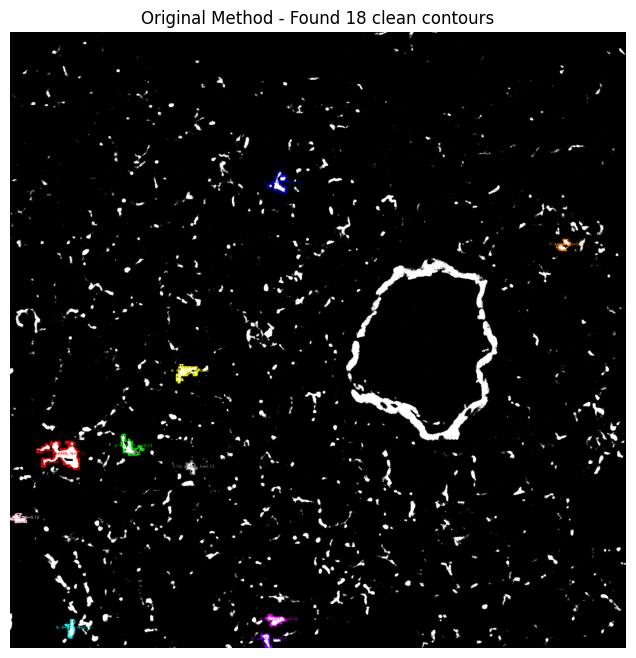

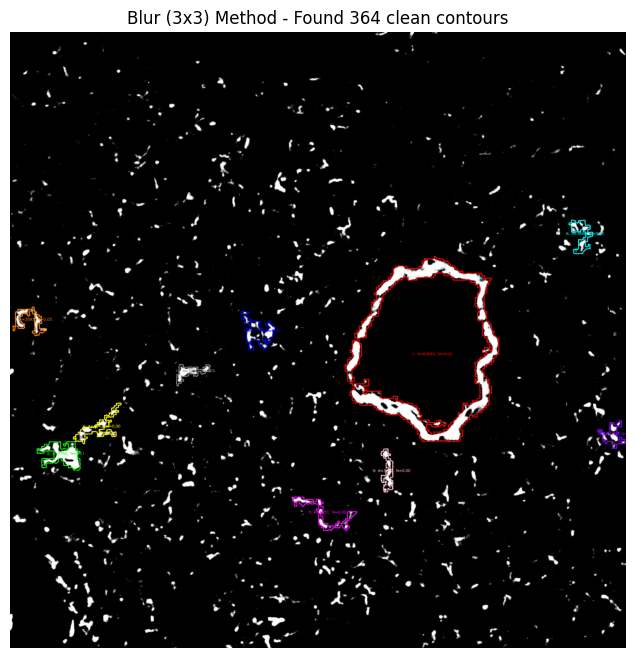

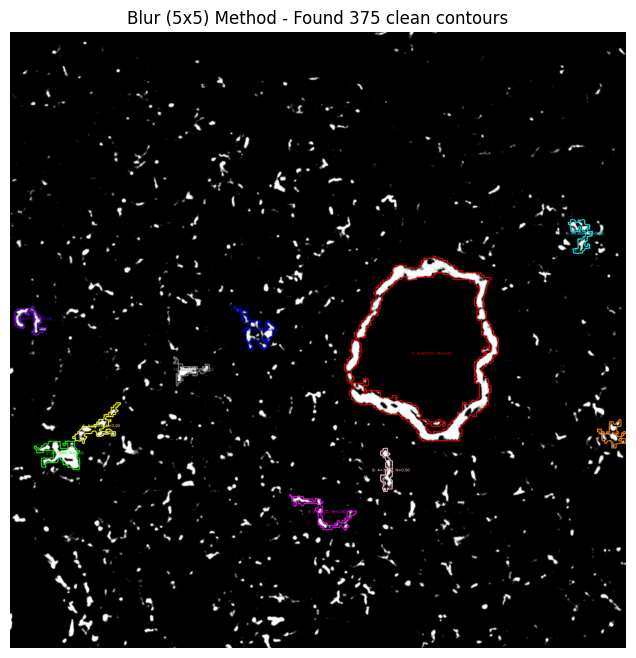

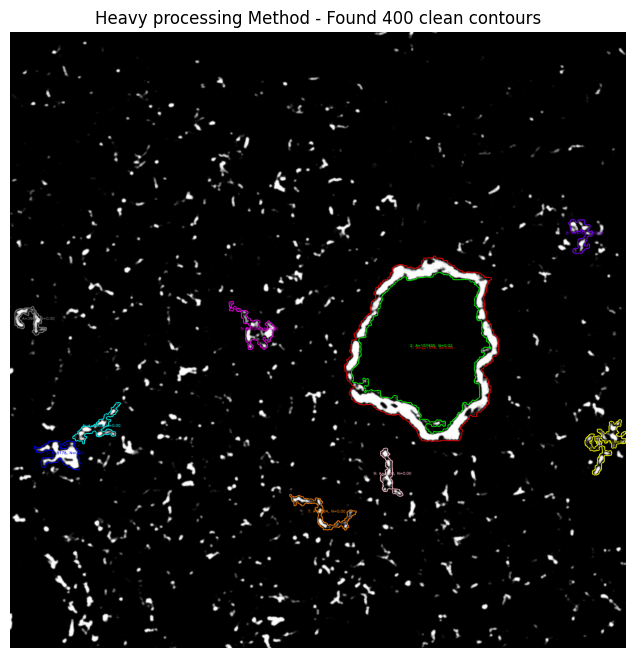

In [ ]:
# Visualize the results
def visualize_clean_contours(img, clean_contours, title="Clean Contours", max_contours=10):
    """
    Visualize clean contours with color coding based on noise level
    """
    img_vis = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Sort by area (largest first)
    sorted_contours = sorted(clean_contours, key=lambda x: x['area'], reverse=True)
    
    colors = [
        (255, 0, 0),    # Red
        (0, 255, 0),    # Green  
        (0, 0, 255),    # Blue
        (255, 255, 0),  # Yellow
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Cyan
        (255, 128, 0),  # Orange
        (128, 0, 255),  # Purple
        (255, 192, 203), # Pink
        (128, 128, 128)  # Gray
    ]
    
    for i, contour_info in enumerate(sorted_contours[:max_contours]):
        contour = contour_info['contour']
        color = colors[i % len(colors)]
        
        # Draw contour
        cv2.drawContours(img_vis, [contour], -1, color, 2)
        
        # Add label with metrics
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            
            metrics = contour_info['noise_metrics']
            label = f"{i+1}: A={int(contour_info['area'])}, N={metrics['noise_ratio']:.2f}"
            cv2.putText(img_vis, label, (cx-50, cy), cv2.FONT_HERSHEY_SIMPLEX, 
                       0.4, color, 1, cv2.LINE_AA)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img_vis)
    plt.title(f"{title} - Found {len(clean_contours)} clean contours")
    plt.axis('off')
    plt.show()
    
    return img_vis

# Visualize each preprocessing method
for method_name, (processed_img, clean_contours, method_results) in results.items():
    if clean_contours:  # Only visualize if we found clean contours
        visualize_clean_contours(processed_img, clean_contours, f"{method_name} Method")

=== Alternative Contour Detection Methods ===
Canny-based detection found 169 large contours (area > 300)
Adaptive threshold found 2 large contours
Otsu threshold found 72 large contours


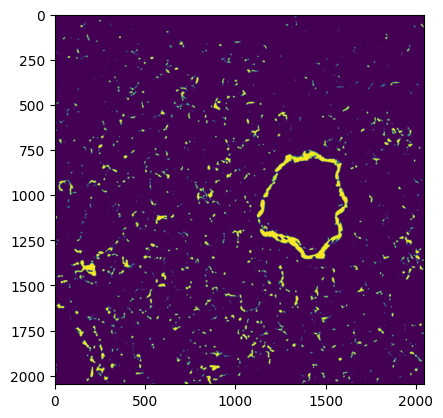

In [ ]:
# Alternative contour detection methods using OpenCV
def canny_based_contours(img, blur_kernel=5, canny_low=50, canny_high=150):
    """
    Use Canny edge detection for better contour finding
    """
    # Blur to reduce noise
    blurred = cv2.GaussianBlur(img, (blur_kernel, blur_kernel), 0)
    
    # Canny edge detection
    edges = cv2.Canny(blurred, canny_low, canny_high)
    
    # Dilate to connect broken edges
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours, edges

def adaptive_threshold_contours(img):
    """
    Use adaptive thresholding for varying illumination
    """
    # Adaptive thresholding
    adaptive_thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                          cv2.THRESH_BINARY, 11, 2)
    
    # Clean up with morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    adaptive_thresh = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(adaptive_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours, adaptive_thresh

def otsu_threshold_contours(img):
    """
    Use Otsu's thresholding for automatic threshold selection
    """
    # Gaussian blur
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    plt.imshow(blurred)
    # Otsu's thresholding
    _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Clean up
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    otsu_thresh = cv2.morphologyEx(otsu_thresh, cv2.MORPH_CLOSE, kernel)
    otsu_thresh = cv2.morphologyEx(otsu_thresh, cv2.MORPH_OPEN, kernel)
    
    # Find contours
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    return contours, otsu_thresh

# Test these methods - First re-run the setup
img_contour_3 = img.copy()

print("=== Alternative Contour Detection Methods ===")

# Method 1: Canny-based
canny_contours, canny_edges = canny_based_contours(img_contour_3)
canny_large_contours = [c for c in canny_contours if cv2.contourArea(c) > 300]
print(f"Canny-based detection found {len(canny_large_contours)} large contours (area > 300)")

# Method 2: Adaptive threshold
adaptive_contours, adaptive_thresh = adaptive_threshold_contours(img_contour_3)
adaptive_large_contours = [c for c in adaptive_contours if cv2.contourArea(c) > 300]
print(f"Adaptive threshold found {len(adaptive_large_contours)} large contours")

# Method 3: Otsu threshold
otsu_contours, otsu_thresh = otsu_threshold_contours(img_contour_3)
otsu_large_contours = [c for c in otsu_contours if cv2.contourArea(c) > 300]
print(f"Otsu threshold found {len(otsu_large_contours)} large contours")

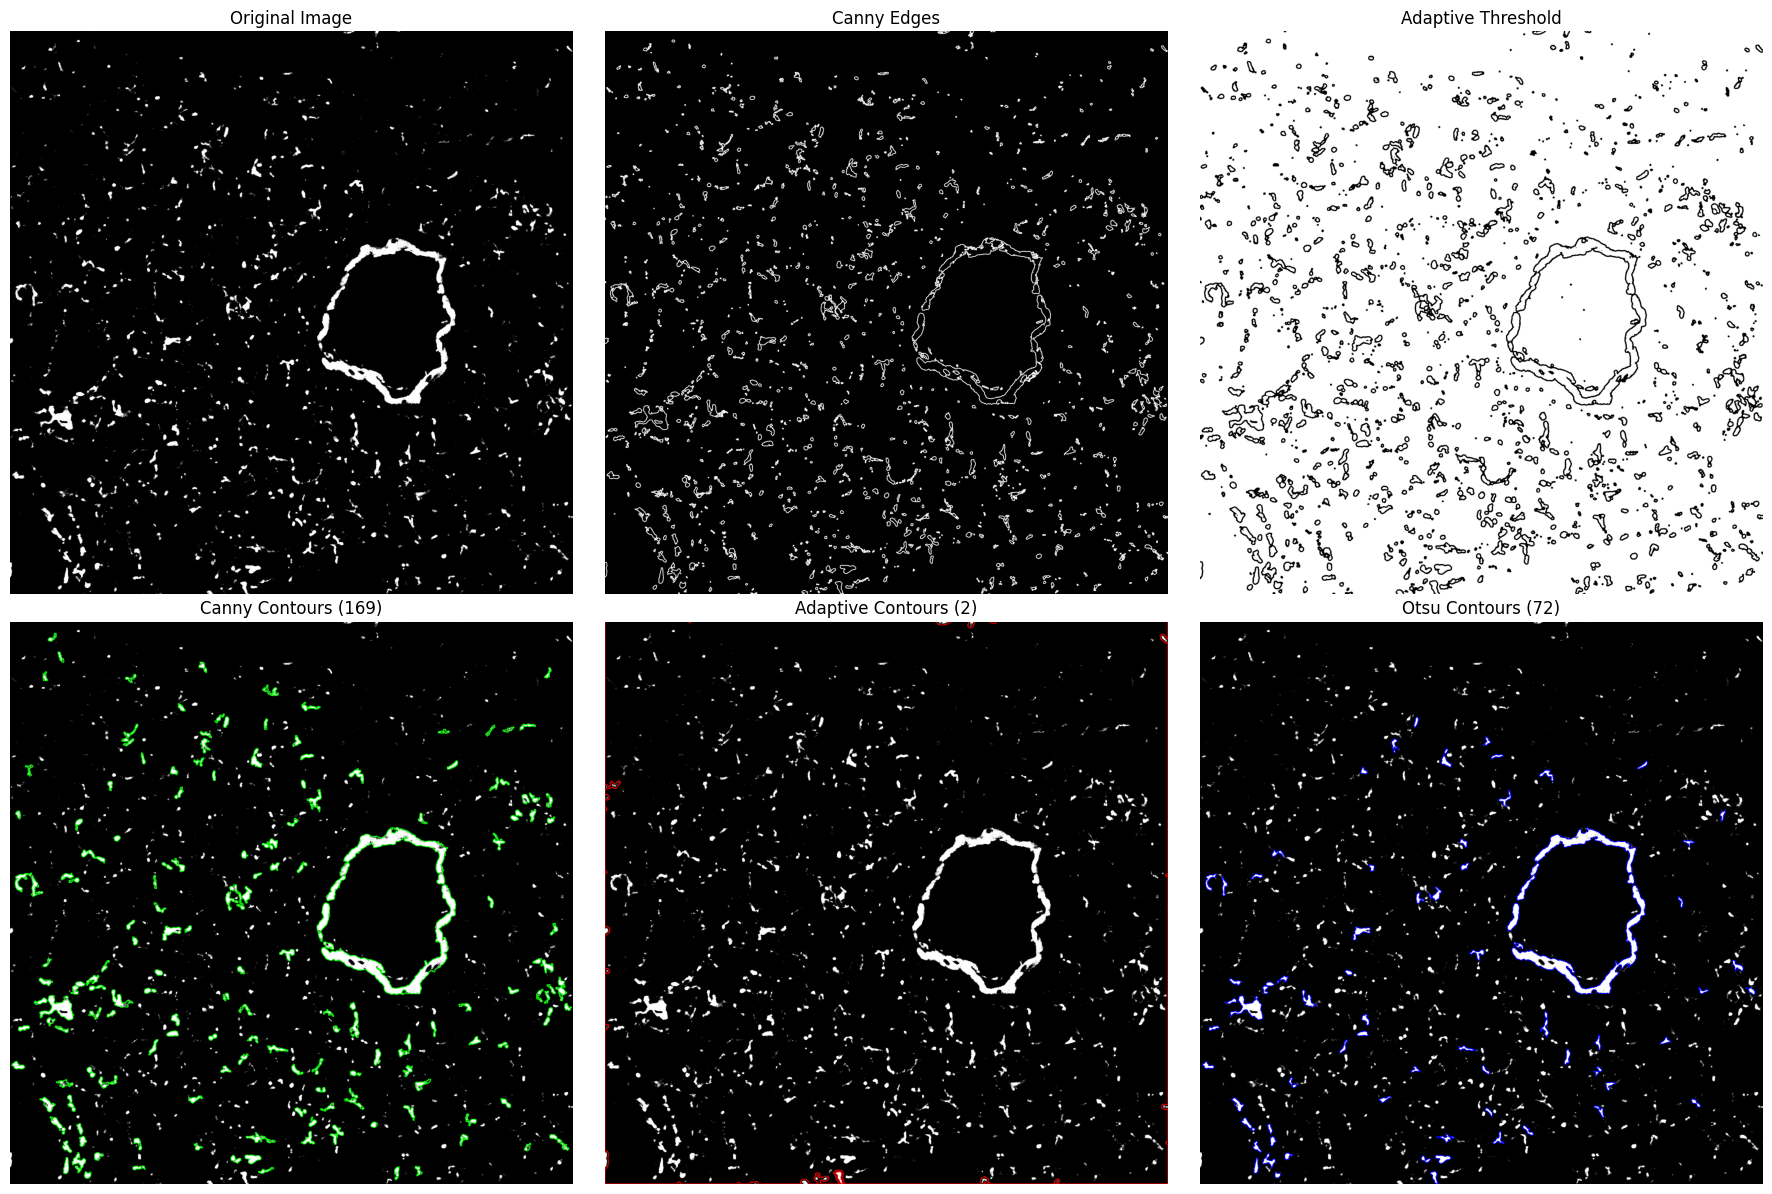

In [ ]:
# Visualize all methods side by side
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original
axes[0, 0].imshow(img_contour_3, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Canny edges
axes[0, 1].imshow(canny_edges, cmap='gray')
axes[0, 1].set_title('Canny Edges')
axes[0, 1].axis('off')

# Adaptive threshold
axes[0, 2].imshow(adaptive_thresh, cmap='gray')
axes[0, 2].set_title('Adaptive Threshold')
axes[0, 2].axis('off')

# Canny contours
img_canny_vis = cv2.cvtColor(img_contour_3, cv2.COLOR_GRAY2RGB)
cv2.drawContours(img_canny_vis, canny_large_contours, -1, (0, 255, 0), 2)
axes[1, 0].imshow(img_canny_vis)
axes[1, 0].set_title(f'Canny Contours ({len(canny_large_contours)})')
axes[1, 0].axis('off')

# Adaptive contours
img_adaptive_vis = cv2.cvtColor(img_contour_3, cv2.COLOR_GRAY2RGB)
cv2.drawContours(img_adaptive_vis, adaptive_large_contours, -1, (255, 0, 0), 2)
axes[1, 1].imshow(img_adaptive_vis)
axes[1, 1].set_title(f'Adaptive Contours ({len(adaptive_large_contours)})')
axes[1, 1].axis('off')

# Otsu contours
img_otsu_vis = cv2.cvtColor(img_contour_3, cv2.COLOR_GRAY2RGB)
cv2.drawContours(img_otsu_vis, otsu_large_contours, -1, (0, 0, 255), 2)
axes[1, 2].imshow(img_otsu_vis)
axes[1, 2].set_title(f'Otsu Contours ({len(otsu_large_contours)})')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

=== OPTIMAL APPROACH ===
Found 318 optimal clean contours
  1. Area: 60840, Noise: 0.000, Compactness: 0.028, Method: standard, Quality: 1707
  2. Area: 24918, Noise: 0.000, Compactness: 0.064, Method: canny, Quality: 1593
  3. Area: 7755, Noise: 0.008, Compactness: 0.166, Method: standard, Quality: 1277
  4. Area: 17178, Noise: 0.001, Compactness: 0.066, Method: canny, Quality: 1134
  5. Area: 2443, Noise: 0.000, Compactness: 0.435, Method: canny, Quality: 1062
  6. Area: 6124, Noise: 0.000, Compactness: 0.129, Method: standard, Quality: 791
  7. Area: 2612, Noise: 0.000, Compactness: 0.276, Method: standard, Quality: 720
  8. Area: 2425, Noise: 0.000, Compactness: 0.286, Method: standard, Quality: 694
  9. Area: 1574, Noise: 0.000, Compactness: 0.420, Method: standard, Quality: 662
  10. Area: 1248, Noise: 0.000, Compactness: 0.527, Method: standard, Quality: 657


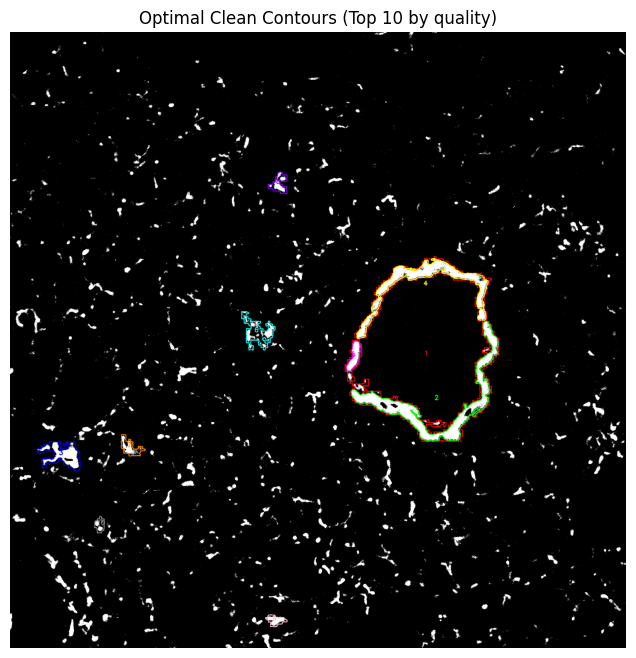

In [ ]:
img_contour_4 = img.copy()
# FINAL RECOMMENDED APPROACH for finding clean, well-outlined regions
def find_optimal_clean_contours(img, min_area=300, max_noise_ratio=0.05):
    """
    Optimal pipeline for finding clean, well-outlined regions
    """
    # Step 1: Light preprocessing
    processed = preprocess_image(img, blur_kernel=(3,3), morphology_kernel=(2,2))
    
    # Step 2: Use multiple methods and combine results
    methods = {
        'standard': cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0],
        'canny': canny_based_contours(processed)[0],
        'otsu': otsu_threshold_contours(processed)[0]
    }
    
    # Step 3: Analyze each contour set
    all_clean_contours = []
    
    for method_name, contours in methods.items():
        for contour in contours:
            area = cv2.contourArea(contour)
            if area < min_area:
                continue
                
            noise_metrics = analyze_contour_noise(processed, contour)
            
            if noise_metrics['noise_ratio'] <= max_noise_ratio:
                # Add quality score based on area/perimeter ratio (compactness)
                perimeter = cv2.arcLength(contour, True)
                compactness = (4 * np.pi * area) / (perimeter * perimeter) if perimeter > 0 else 0
                
                all_clean_contours.append({
                    'contour': contour,
                    'area': area,
                    'noise_metrics': noise_metrics,
                    'compactness': compactness,
                    'method': method_name,
                    'quality_score': area * (1 - noise_metrics['noise_ratio']) * compactness
                })
    
    # Step 4: Remove duplicates and sort by quality
    # (Simple approach: remove contours that are too close to each other)
    unique_contours = []
    for contour_info in sorted(all_clean_contours, key=lambda x: x['quality_score'], reverse=True):
        is_duplicate = False
        for existing in unique_contours:
            # Check if centroids are close
            M1 = cv2.moments(contour_info['contour'])
            M2 = cv2.moments(existing['contour'])
            if M1["m00"] > 0 and M2["m00"] > 0:
                cx1, cy1 = int(M1["m10"] / M1["m00"]), int(M1["m01"] / M1["m00"])
                cx2, cy2 = int(M2["m10"] / M2["m00"]), int(M2["m01"] / M2["m00"])
                distance = np.sqrt((cx1-cx2)**2 + (cy1-cy2)**2)
                if distance < 50:  # Threshold for "too close"
                    is_duplicate = True
                    break
        
        if not is_duplicate:
            unique_contours.append(contour_info)
    
    return unique_contours

# Apply the optimal approach
print("=== OPTIMAL APPROACH ===")
optimal_contours = find_optimal_clean_contours(img_contour_4, min_area=300, max_noise_ratio=0.05)

print(f"Found {len(optimal_contours)} optimal clean contours")
for i, contour_info in enumerate(optimal_contours[:10]):  # Show top 10
    print(f"  {i+1}. Area: {contour_info['area']:.0f}, "
          f"Noise: {contour_info['noise_metrics']['noise_ratio']:.3f}, "
          f"Compactness: {contour_info['compactness']:.3f}, "
          f"Method: {contour_info['method']}, "
          f"Quality: {contour_info['quality_score']:.0f}")

# Visualize the optimal results
img_optimal_vis = cv2.cvtColor(img_contour_4, cv2.COLOR_GRAY2RGB)
colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0), (255,0,255), 
          (0,255,255), (255,128,0), (128,0,255), (255,192,203), (128,128,128)]

for i, contour_info in enumerate(optimal_contours[:10]):
    contour = contour_info['contour']
    color = colors[i % len(colors)]
    cv2.drawContours(img_optimal_vis, [contour], -1, color, 2)
    
    # Add label
    M = cv2.moments(contour)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        cv2.putText(img_optimal_vis, str(i+1), (cx-10, cy), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

plt.figure(figsize=(12, 8))
plt.imshow(img_optimal_vis)
plt.title(f"Optimal Clean Contours (Top {min(10, len(optimal_contours))} by quality)")
plt.axis('off')
plt.show()